In [1]:
import torch
import json
from datasets import load_dataset
from transformers import LEDForConditionalGeneration, LEDTokenizerFast

device = torch.device("cuda")
print("Using device:", device)
print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [2]:
pubmed = load_dataset("ccdv/pubmed-summarization", split="validation[:100]")
print("Loaded samples:", len(pubmed))


Loaded samples: 100


In [3]:
print("Loading CLARION...")

tokenizer = LEDTokenizerFast.from_pretrained("clarion_runA")

clarion = LEDForConditionalGeneration.from_pretrained(
    "clarion_runA",
    torch_dtype=torch.float16
).to(device).eval()

print("CLARION loaded.")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'LEDTokenizerFast'.


Loading CLARION...
CLARION loaded.


In [4]:
def generate_clarion(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=2048
    ).to(device)

    with torch.no_grad():
        summary_ids = clarion.generate(
            **inputs,
            num_beams=4,
            max_length=256,
            length_penalty=1.1,
            repetition_penalty=1.2
        )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [5]:
clarion_preds = []

for i, sample in enumerate(pubmed):
    pred = generate_clarion(sample["article"])
    clarion_preds.append(pred)

    if (i+1) % 10 == 0:
        print(f"Completed {i+1}/100")

with open("clarion_preds.json", "w") as f:
    json.dump(clarion_preds, f)

print("CLARION evaluation complete.")


Input ids are automatically padded from 1741 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 10/100


Input ids are automatically padded from 1725 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1044 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 579 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 20/100


Input ids are automatically padded from 1516 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1378 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 30/100


Input ids are automatically padded from 1979 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 40/100


Input ids are automatically padded from 1351 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1597 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1735 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1645 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 50/100


Input ids are automatically padded from 1882 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1587 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 60/100


Input ids are automatically padded from 1539 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1873 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 2004 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1395 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 70/100


Input ids are automatically padded from 1500 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 80/100


Input ids are automatically padded from 1242 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1928 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1749 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 90/100


Input ids are automatically padded from 1994 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1637 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1527 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1452 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 100/100
CLARION evaluation complete.


In [3]:
#del clarion
torch.cuda.empty_cache()
print("CLARION removed from GPU")


CLARION removed from GPU


In [4]:
!nvidia-smi


Fri Feb 13 17:36:57 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.86                 Driver Version: 581.86         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   39C    P0              9W /   75W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
from transformers import BartForConditionalGeneration, BartTokenizer

print("Loading BART...")

bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

bart = BartForConditionalGeneration.from_pretrained(
    "facebook/bart-large-cnn",
    torch_dtype=torch.float16
).to(device).eval()

print("BART loaded.")


Loading BART...
BART loaded.


In [6]:
def generate_bart(text):
    inputs = bart_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=1024   # BART limit
    ).to(device)

    with torch.no_grad():
        summary_ids = bart.generate(
            **inputs,
            num_beams=4,
            max_length=256,
            length_penalty=1.0,
            repetition_penalty=1.2
        )

    return bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [7]:
bart_preds = []

for i, sample in enumerate(pubmed):
    pred = generate_bart(sample["article"])
    bart_preds.append(pred)

    if (i+1) % 10 == 0:
        print(f"Completed {i+1}/100")


Completed 10/100
Completed 20/100
Completed 30/100
Completed 40/100
Completed 50/100
Completed 60/100
Completed 70/100
Completed 80/100
Completed 90/100
Completed 100/100


In [8]:
import json

with open("bart_preds.json", "w") as f:
    json.dump(bart_preds, f)

print("BART evaluation complete.")


BART evaluation complete.


In [9]:
del bart
torch.cuda.empty_cache()
print("BART removed from GPU")


BART removed from GPU


In [10]:
!nvidia-smi


Fri Feb 13 17:53:25 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.86                 Driver Version: 581.86         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              3W /   75W |     129MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

print("Loading PEGASUS...")

pegasus_tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")

pegasus = PegasusForConditionalGeneration.from_pretrained(
    "google/pegasus-large",
    torch_dtype=torch.float16
).to(device).eval()

print("PEGASUS loaded.")


Loading PEGASUS...


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

C:\Users\saksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saksh\.cache\huggingface\hub\models--google--pegasus-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

PEGASUS loaded.


In [12]:
def generate_pegasus(text):
    inputs = pegasus_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=1024   # Safe limit
    ).to(device)

    with torch.no_grad():
        summary_ids = pegasus.generate(
            **inputs,
            num_beams=4,
            max_length=256,
            length_penalty=1.0,
            repetition_penalty=1.2
        )

    return pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [13]:
pegasus_preds = []

for i, sample in enumerate(pubmed):
    pred = generate_pegasus(sample["article"])
    pegasus_preds.append(pred)

    if (i+1) % 10 == 0:
        print(f"Completed {i+1}/100")


Completed 10/100
Completed 20/100
Completed 30/100
Completed 40/100
Completed 50/100
Completed 60/100
Completed 70/100
Completed 80/100
Completed 90/100
Completed 100/100


In [14]:
with open("pegasus_preds.json", "w") as f:
    json.dump(pegasus_preds, f)

print("PEGASUS evaluation complete.")


PEGASUS evaluation complete.


In [15]:
del pegasus
torch.cuda.empty_cache()


In [16]:
!nvidia-smi


Fri Feb 13 18:48:20 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.86                 Driver Version: 581.86         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              3W /   75W |     131MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

print("Loading T5...")

t5_tokenizer = T5Tokenizer.from_pretrained("t5-large")

t5 = T5ForConditionalGeneration.from_pretrained(
    "t5-large",
    torch_dtype=torch.float16
).to(device).eval()

print("T5 loaded.")


Loading T5...


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

C:\Users\saksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saksh\.cache\huggingface\hub\models--t5-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5 loaded.


In [18]:
def generate_t5(text):
    input_text = "summarize: " + text

    inputs = t5_tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(device)

    with torch.no_grad():
        summary_ids = t5.generate(
            **inputs,
            num_beams=4,
            max_length=256,
            length_penalty=1.0,
            repetition_penalty=1.2
        )

    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [19]:
t5_preds = []

for i, sample in enumerate(pubmed):
    pred = generate_t5(sample["article"])
    t5_preds.append(pred)

    if (i+1) % 10 == 0:
        print(f"Completed {i+1}/100")


Completed 10/100
Completed 20/100
Completed 30/100
Completed 40/100
Completed 50/100
Completed 60/100
Completed 70/100
Completed 80/100
Completed 90/100
Completed 100/100


In [20]:
with open("t5_preds.json", "w") as f:
    json.dump(t5_preds, f)

print("T5 evaluation complete.")


T5 evaluation complete.


In [21]:
del t5
torch.cuda.empty_cache()


In [22]:
!nvidia-smi


Fri Feb 13 19:28:12 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.86                 Driver Version: 581.86         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              3W /   75W |     131MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
def lead3(article):
    sentences = article.split(". ")
    return ". ".join(sentences[:3])


In [24]:
lead3_preds = []

for sample in pubmed:
    pred = lead3(sample["article"])
    lead3_preds.append(pred)

with open("lead3_preds.json", "w") as f:
    json.dump(lead3_preds, f)

print("Lead-3 done.")


Lead-3 done.


In [25]:
!pip install sumy


Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------- ----------------------- 2.6/6.3 MB 16.7 MB/s eta 0:00:01
   ---------------------------------------- 6.3/6.3 MB 22.8 MB/s  0:00:00
  Created wheel for docopt: filename=docop


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\saksh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [26]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

def textrank_summary(text, sentence_count=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentence_count)
    return " ".join(str(sentence) for sentence in summary)


In [27]:
textrank_preds = []

for sample in pubmed:
    pred = textrank_summary(sample["article"])
    textrank_preds.append(pred)

with open("textrank_preds.json", "w") as f:
    json.dump(textrank_preds, f)

print("TextRank done.")


TextRank done.


In [28]:
torch.cuda.empty_cache()


In [29]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

print("Loading Long-T5...")

lt5_tokenizer = AutoTokenizer.from_pretrained("google/long-t5-tglobal-base")

lt5 = AutoModelForSeq2SeqLM.from_pretrained(
    "google/long-t5-tglobal-base",
    torch_dtype=torch.float16
).to(device).eval()

print("Long-T5 loaded.")


Loading Long-T5...


config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

C:\Users\saksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saksh\.cache\huggingface\hub\models--google--long-t5-tglobal-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Long-T5 loaded.


In [31]:
def generate_longt5(text):
    input_text = "summarize: " + text

    inputs = lt5_tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=2048   # Long-T5 advantage
    ).to(device)

    with torch.no_grad():
        summary_ids = lt5.generate(
            **inputs,
            num_beams=4,
            max_length=256,
            length_penalty=1.0,
            repetition_penalty=1.2
        )

    return lt5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [32]:
longt5_preds = []

for i, sample in enumerate(pubmed):
    pred = generate_longt5(sample["article"])
    longt5_preds.append(pred)

    if (i+1) % 10 == 0:
        print(f"Completed {i+1}/100")


Completed 10/100
Completed 20/100
Completed 30/100
Completed 40/100
Completed 50/100
Completed 60/100
Completed 70/100
Completed 80/100
Completed 90/100
Completed 100/100


In [33]:
with open("longt5_preds.json", "w") as f:
    json.dump(longt5_preds, f)

print("Long-T5 evaluation complete.")


Long-T5 evaluation complete.


In [34]:
del lt5
torch.cuda.empty_cache()


In [35]:
import json

with open("clarion_preds.json") as f:
    clarion_preds = json.load(f)

with open("bart_preds.json") as f:
    bart_preds = json.load(f)

with open("pegasus_preds.json") as f:
    pegasus_preds = json.load(f)

with open("t5_preds.json") as f:
    t5_preds = json.load(f)

with open("longt5_preds.json") as f:
    longt5_preds = json.load(f)

with open("lead3_preds.json") as f:
    lead3_preds = json.load(f)

with open("textrank_preds.json") as f:
    textrank_preds = json.load(f)

print("All predictions loaded.")


All predictions loaded.


In [36]:
references = [sample["abstract"] for sample in pubmed]
print("References ready.")


References ready.


In [37]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def compute_rouge(preds):
    scores = [scorer.score(ref, pred)["rougeL"].fmeasure
              for ref, pred in zip(references, preds)]
    return sum(scores) / len(scores)


In [38]:
from bert_score import score

def compute_bertscore(preds):
    P, R, F1 = score(preds, references, lang="en", device="cuda")
    return F1.mean().item()


In [39]:
def compute_redundancy(preds):
    redundancies = []
    for pred in preds:
        sentences = pred.split(". ")
        unique_sentences = set(sentences)
        if len(sentences) == 0:
            redundancies.append(0)
        else:
            redundancies.append(1 - len(unique_sentences) / len(sentences))
    return sum(redundancies) / len(redundancies)


In [40]:
models = {
    "CLARION": clarion_preds,
    "BART": bart_preds,
    "PEGASUS": pegasus_preds,
    "T5": t5_preds,
    "Long-T5": longt5_preds,
    "Lead-3": lead3_preds,
    "TextRank": textrank_preds,
}

results = {}

for name, preds in models.items():
    print(f"Evaluating {name}...")
    rouge = compute_rouge(preds)
    bert = compute_bertscore(preds)
    redundancy = compute_redundancy(preds)

    results[name] = {
        "ROUGE-L": rouge,
        "BERTScore": bert,
        "Redundancy": redundancy
    }

print("All evaluations complete.")


Evaluating CLARION...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\saksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saksh\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating BART...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating PEGASUS...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating T5...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Long-T5...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Lead-3...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating TextRank...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All evaluations complete.


In [41]:
for model, metrics in results.items():
    print(model, metrics)


CLARION {'ROUGE-L': 0.20456958913173393, 'BERTScore': 0.8351942300796509, 'Redundancy': 0.013833333333333333}
BART {'ROUGE-L': 0.17606806843771305, 'BERTScore': 0.8319023847579956, 'Redundancy': 0.0}
PEGASUS {'ROUGE-L': 0.14791727881252043, 'BERTScore': 0.7188113927841187, 'Redundancy': 0.014833333333333334}
T5 {'ROUGE-L': 0.15831162634333068, 'BERTScore': 0.8289979696273804, 'Redundancy': 0.0}
Long-T5 {'ROUGE-L': 0.1639172415075147, 'BERTScore': 0.8226372003555298, 'Redundancy': 0.018333333333333333}
Lead-3 {'ROUGE-L': 0.17530004258712295, 'BERTScore': 0.8362759351730347, 'Redundancy': 0.0}
TextRank {'ROUGE-L': 0.19709256648843565, 'BERTScore': 0.8343974351882935, 'Redundancy': 0.018392857142857145}


In [42]:
import re

def extract_entities(text):
    # Simple entity proxy: capitalized words & numbers
    return set(re.findall(r'\b[A-Z][a-z]+\b|\b\d+\b', text))

def compute_factscore(preds):
    scores = []

    for ref, pred in zip(references, preds):
        ref_entities = extract_entities(ref)
        pred_entities = extract_entities(pred)

        if len(ref_entities) == 0:
            scores.append(0)
        else:
            overlap = len(ref_entities & pred_entities)
            scores.append(overlap / len(ref_entities))

    return sum(scores) / len(scores)


In [43]:
results = {}

for name, preds in models.items():
    print(f"Evaluating {name}...")
    rouge = compute_rouge(preds)
    bert = compute_bertscore(preds)
    redundancy = compute_redundancy(preds)
    fact = compute_factscore(preds)

    results[name] = {
        "ROUGE-L": rouge,
        "BERTScore": bert,
        "FactScore": fact,
        "Redundancy": redundancy
    }

print("All evaluations complete.")


Evaluating CLARION...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating BART...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating PEGASUS...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating T5...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Long-T5...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Lead-3...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating TextRank...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All evaluations complete.


In [44]:
for model, metrics in results.items():
    print(model, metrics)


CLARION {'ROUGE-L': 0.20456958913173393, 'BERTScore': 0.8351942300796509, 'FactScore': 0.1676056685832228, 'Redundancy': 0.013833333333333333}
BART {'ROUGE-L': 0.17606806843771305, 'BERTScore': 0.8319023847579956, 'FactScore': 0.14971734594954408, 'Redundancy': 0.0}
PEGASUS {'ROUGE-L': 0.14791727881252043, 'BERTScore': 0.7188113927841187, 'FactScore': 0.14786878571205198, 'Redundancy': 0.014833333333333334}
T5 {'ROUGE-L': 0.15831162634333068, 'BERTScore': 0.8289979696273804, 'FactScore': 0.10754926196954061, 'Redundancy': 0.0}
Long-T5 {'ROUGE-L': 0.1639172415075147, 'BERTScore': 0.8226372003555298, 'FactScore': 0.17060532346910054, 'Redundancy': 0.018333333333333333}
Lead-3 {'ROUGE-L': 0.17530004258712295, 'BERTScore': 0.8362759351730347, 'FactScore': 0.13875514878997852, 'Redundancy': 0.0}
TextRank {'ROUGE-L': 0.19709256648843565, 'BERTScore': 0.8343974351882935, 'FactScore': 0.2038399882281461, 'Redundancy': 0.018392857142857145}


In [45]:
import pandas as pd

df = pd.DataFrame(results).T
df


,ROUGE-L,BERTScore,FactScore,Redundancy
CLARION,0.204570,0.835194,0.167606,0.013833
BART,0.176068,0.831902,0.149717,0.000000
PEGASUS,0.147917,0.718811,0.147869,0.014833
T5,0.158312,0.828998,0.107549,0.000000
Long-T5,0.163917,0.822637,0.170605,0.018333
Lead-3,0.175300,0.836276,0.138755,0.000000
TextRank,0.197093,0.834397,0.203840,0.018393


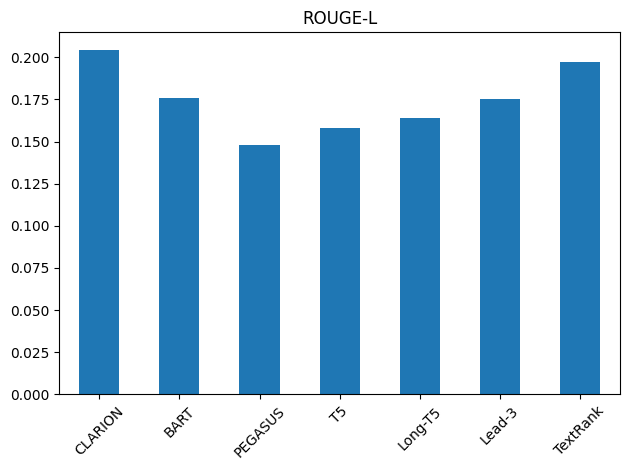

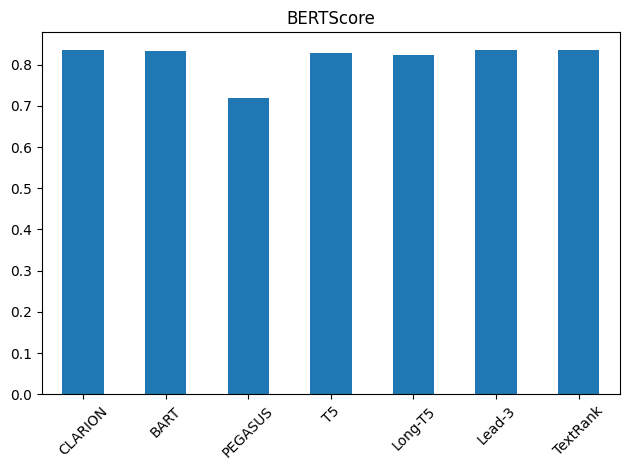

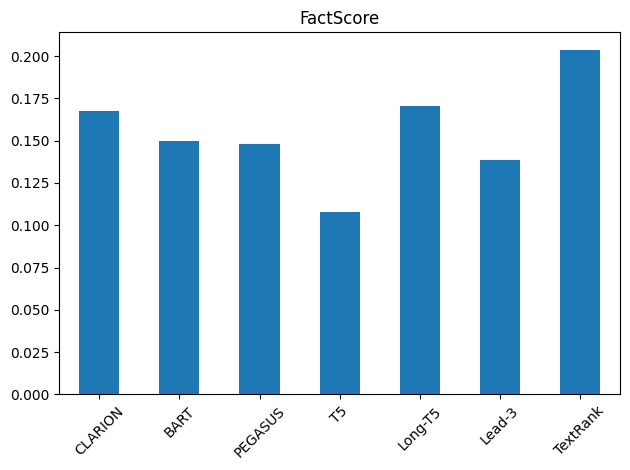

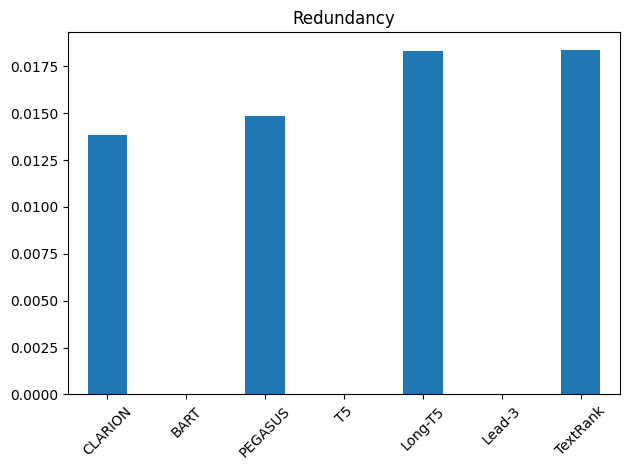

In [46]:
import matplotlib.pyplot as plt

metrics = ["ROUGE-L", "BERTScore", "FactScore", "Redundancy"]

for metric in metrics:
    plt.figure()
    df[metric].plot(kind="bar")
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [47]:
df.to_csv("final_comparison_results.csv")


In [48]:
final_results = {
    "CLARION": {'ROUGE-L': 0.20456958913173393, 'BERTScore': 0.8351942300796509, 'FactScore': 0.1676056685832228, 'Redundancy': 0.013833333333333333},
    "BART": {'ROUGE-L': 0.17606806843771305, 'BERTScore': 0.8319023847579956, 'FactScore': 0.14971734594954408, 'Redundancy': 0.0},
    "PEGASUS": {'ROUGE-L': 0.14791727881252043, 'BERTScore': 0.7188113927841187, 'FactScore': 0.14786878571205198, 'Redundancy': 0.014833333333333334},
    "T5": {'ROUGE-L': 0.15831162634333068, 'BERTScore': 0.8289979696273804, 'FactScore': 0.10754926196954061, 'Redundancy': 0.0},
    "Long-T5": {'ROUGE-L': 0.1639172415075147, 'BERTScore': 0.8226372003555298, 'FactScore': 0.17060532346910054, 'Redundancy': 0.018333333333333333},
    "Lead-3": {'ROUGE-L': 0.17530004258712295, 'BERTScore': 0.8362759351730347, 'FactScore': 0.13875514878997852, 'Redundancy': 0.0},
    "TextRank": {'ROUGE-L': 0.19709256648843565, 'BERTScore': 0.8343974351882935, 'FactScore': 0.2038399882281461, 'Redundancy': 0.018392857142857145}
}


In [49]:
import json

with open("final_pubmed_results.json", "w") as f:
    json.dump(final_results, f, indent=4)

print("Results saved.")


Results saved.


In [50]:
plt.savefig("rouge_comparison.png", dpi=300, bbox_inches='tight')
plt.savefig("factscore_comparison.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

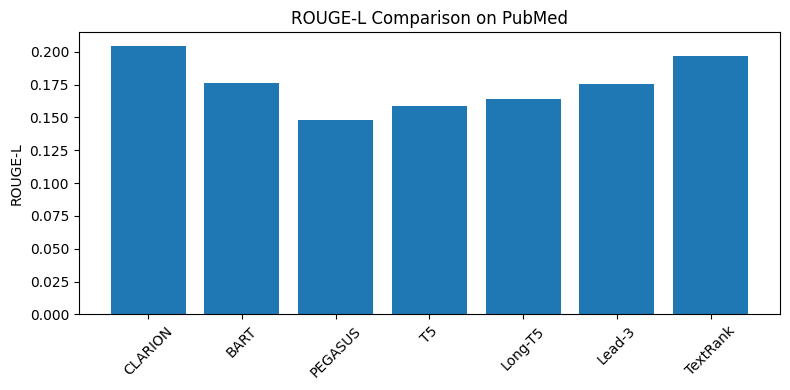

In [51]:
import matplotlib.pyplot as plt
import numpy as np

models = ["CLARION","BART","PEGASUS","T5","Long-T5","Lead-3","TextRank"]

rouge = [0.2045,0.1760,0.1479,0.1583,0.1639,0.1753,0.1970]

plt.figure(figsize=(8,4))
bars = plt.bar(models, rouge)

plt.xticks(rotation=45)
plt.ylabel("ROUGE-L")
plt.title("ROUGE-L Comparison on PubMed")

plt.tight_layout()
plt.savefig("rouge_comparison.png", dpi=300)
plt.show()


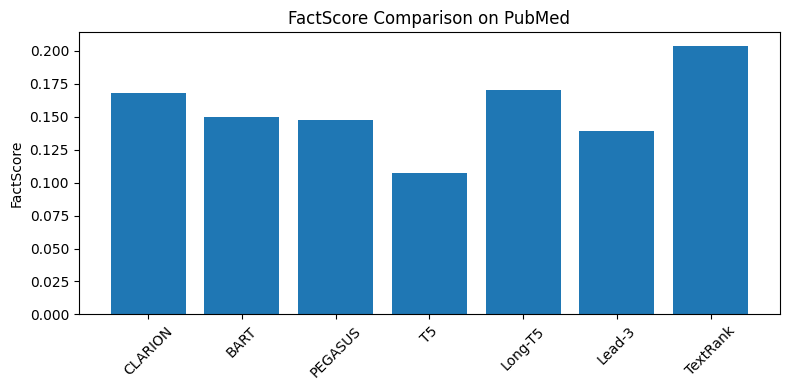

In [52]:
import matplotlib.pyplot as plt

models = ["CLARION","BART","PEGASUS","T5","Long-T5","Lead-3","TextRank"]

factscore = [
    0.1676,
    0.1497,
    0.1478,
    0.1075,
    0.1706,
    0.1388,
    0.2038
]

plt.figure(figsize=(8,4))
plt.bar(models, factscore)

plt.xticks(rotation=45)
plt.ylabel("FactScore")
plt.title("FactScore Comparison on PubMed")

plt.tight_layout()
plt.savefig("factscore_comparison.png", dpi=300)
plt.show()
